# Exploring Gini and Lorenz

See Bernasco and Steenbeck - *More Places than Crimes: Implications for Evaluating
the Law of Crime Concentration at Place*

Specifically identifying a baseline curve from which a concentration measure can be computed 

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import CATEGORIES, extract_crime_data, lorenz_curve


In [21]:
FORCE = "West Yorkshire"
CATEGORY = CATEGORIES[1]  # ASB
AREA: SpatialUnit = "HEX"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "GC"},
        "GRID": {"size": 800.0},
        "HEX": {"size": 496.0},
        "H3": {"resolution": 8},
    },
)
AREA_THRESHOLDS = [0.5, 0.25, 0.1]

In [22]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(FORCE, filters={"Crime type": CATEGORY})
# remove any points outside boundary
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
raw_crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,
NaN,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Brodrick Drive,E01010692,Bradford 001D,Anti-social behaviour,POINT (411548.009 447086.021)
NaN,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Stourton Road,E01010694,Bradford 002C,Anti-social behaviour,POINT (410926.992 448034.054)
NaN,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Sports/Recreation Area,E01010694,Bradford 002C,Anti-social behaviour,POINT (411796.001 448135.957)
NaN,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Sports/Recreation Area,E01010694,Bradford 002C,Anti-social behaviour,POINT (411986.027 448445.972)
NaN,2022-06,West Yorkshire Police,West Yorkshire Police,On or near Denton Road,E01010694,Bradford 002C,Anti-social behaviour,POINT (412072.989 448382.997)
...,...,...,...,...,...,...,...,...
NaN,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446666.975 410800.005)
NaN,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Holmsley Avenue,E01011864,Wakefield 045A,Anti-social behaviour,POINT (444280.028 410671.995)
NaN,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Holmsley Grove,E01011864,Wakefield 045A,Anti-social behaviour,POINT (444269.023 410709.054)


In [23]:
crime_data, features = map_to_spatial_unit(raw_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])

count_data = (
    crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .reindex(features.index, fill_value=0)
)
assert len(count_data) == len(features)

count_data

Month,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,...,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
85,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
5333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: title={'center': 'Lorenz Curves for Crime Counts by Month'}>

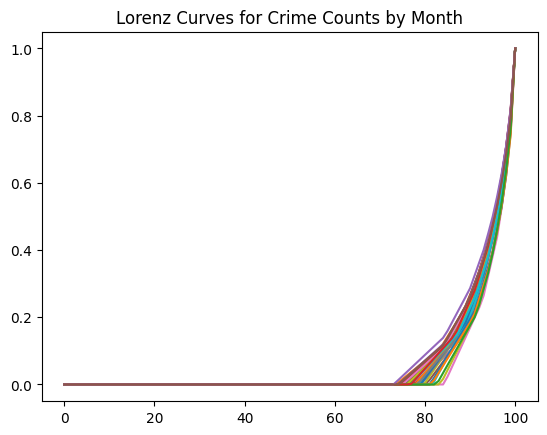

In [25]:
# calculate Lorenz curves
data={m: lorenz_curve(c, percentiles=True) for m, c in count_data.items()}
lorenz_curves = pd.DataFrame(data)
lorenz_curves.plot(legend=False, title="Lorenz Curves for Crime Counts by Month")

In [119]:
n_spatial_units = len(features)
n_crimes_per_month = round(count_data.sum().mean())
mu = n_crimes_per_month / n_spatial_units
n_crimes_per_month, n_spatial_units, mu # the mean count of incidents

(2284, 3367, 0.6783486783486784)

In [123]:
rng = np.random.default_rng()

def get_sample(n_spatial_units, n_crimes_per_month) -> pd.Series:
    raw = rng.choice(range(n_spatial_units), n_crimes_per_month)
    indices, counts = np.unique(raw, return_counts=True)

    sample = pd.Series(index=indices, data=counts).reindex(range(n_spatial_units), fill_value=0)
    return sample

sample = get_sample(n_spatial_units, n_crimes_per_month)


In [ ]:
counts = sample.groupby(sample).count()


0    1703
1    1170
2     386
3      92
4      14
5       2
dtype: int64

In [ ]:

indices, counts = np.unique(samples, return_counts=True)
counts = pd.Series(index=indices, data=counts / n_spatial_units, name="simulated").to_frame()

counts.loc[0] = 1.0 - counts.sum()

counts = counts.sort_index()

dist = poisson(mu)

counts["dist"] = counts.index.map(dist.pmf) # * n_spatial_units
ax = counts.simulated.plot.bar()
ax.plot(counts.dist, c="r", marker="o")
ax.set_xlabel("Incidents per spatial unit")
ax.set_ylabel("Proportion of spatial units")

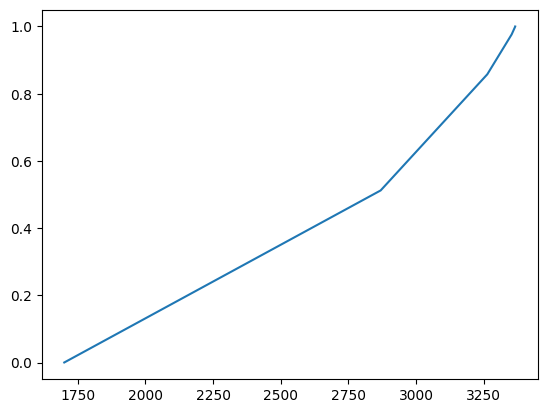

In [ ]:
lorenz_curve = np.sort(samples).cumsum() / samples.sum()

#len(samples), n_spatial_units
ax = plt.plot(range(n_spatial_units - len(samples), n_spatial_units), lorenz_curve)
